In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
import statsmodels.api as sm

from src.visualization.charts import ModelCharts
from src.visualization.metrics import PredictionEvaluator
from src.config import Config

## Load the data

In [2]:
config = Config()
variant_co2 = 'co2'
x_train_df = pd.read_csv(os.path.join(config.output_cleaned_arimax, f'{variant_co2}/exog_train.csv')).set_index(['year'])
x_test_df = pd.read_csv(os.path.join(config.output_cleaned_arimax, f'{variant_co2}/exog_test.csv')).set_index(['year'])

y_train_df = pd.read_csv(os.path.join(config.output_cleaned_arimax, f'{variant_co2}/y_train.csv')).set_index(['year'])
y_test_df = pd.read_csv(os.path.join(config.output_cleaned_arimax, f'{variant_co2}/y_test.csv')).set_index(['year'])


In [3]:
x_train_df

,country_order,country_index,population_lag_1,population_lag_2,gdp_lag_1,gdp_lag_2,temperature_change_from_co2_lag_1,temperature_change_from_co2_lag_2,cement_co2_lag_1,cement_co2_lag_2,coal_co2_lag_1,coal_co2_lag_2,flaring_co2_lag_1,flaring_co2_lag_2,gas_co2_lag_1,gas_co2_lag_2,land_use_change_co2_lag_1,land_use_change_co2_lag_2,oil_co2_lag_1,oil_co2_lag_2
year,,,,,,,,,,,,,,,,,,,,
1853,0,Stany Zjednoczone,25040692.0,24309683.0,1.001978e+11,9.221132e+10,0.001,0.000,0.000,0.000,26.791,24.633,0.000,0.000,0.000,0.000,914.353,861.796,0.000,0.000
1854,0,Stany Zjednoczone,25793143.0,25040692.0,1.109706e+11,1.001978e+11,0.001,0.001,0.000,0.000,30.162,26.791,0.000,0.000,0.000,0.000,925.059,914.353,0.000,0.000
1855,0,Stany Zjednoczone,26568199.0,25793143.0,1.143574e+11,1.109706e+11,0.002,0.001,0.000,0.000,33.159,30.162,0.000,0.000,0.000,0.000,962.976,925.059,0.000,0.000
1856,0,Stany Zjednoczone,27366540.0,26568199.0,1.153065e+11,1.143574e+11,0.002,0.002,0.000,0.000,38.161,33.159,0.000,0.000,0.000,0.000,974.394,962.976,0.000,0.000
1857,0,Stany Zjednoczone,28188865.0,27366540.0,1.212059e+11,1.153065e+11,0.002,0.002,0.000,0.000,40.037,38.161,0.000,0.000,0.000,0.000,1004.712,974.394,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,44,Szwecja,8826299.0,8780193.0,2.517411e+11,2.415243e+11,0.002,0.002,1.296,1.109,11.224,11.237,0.337,0.295,2.061,2.027,-5.795,-9.706,44.029,44.745
1997,44,Szwecja,8840329.0,8826299.0,2.564989e+11,2.517411e+11,0.002,0.002,1.225,1.296,12.388,11.224,0.322,0.337,2.224,2.061,-7.621,-5.795,46.635,44.029
1998,44,Szwecja,8845524.0,8840329.0,2.641711e+11,2.564989e+11,0.002,0.002,1.105,1.225,10.784,12.388,0.358,0.322,2.254,2.224,-6.650,-7.621,43.282,46.635


In [4]:
y_train_df

,country_order,country_index,co2
year,,,
1853,0,Stany Zjednoczone,955.221
1854,0,Stany Zjednoczone,996.135
1855,0,Stany Zjednoczone,1012.554
1856,0,Stany Zjednoczone,1044.748
1857,0,Stany Zjednoczone,1058.979
...,...,...,...
1996,44,Szwecja,55.760
1997,44,Szwecja,51.733
1998,44,Szwecja,52.883


## Check seasonal and stationarity for one country (United States)

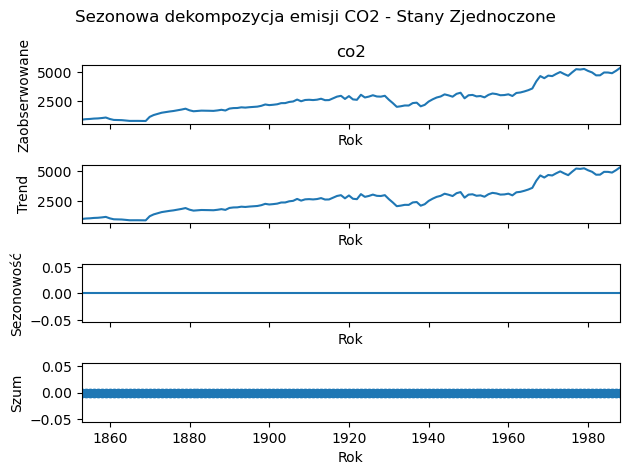

In [5]:
#Check seasonal
df_us = pd.concat([x_train_df, y_train_df['co2']], axis=1)
df_us = df_us[df_us['country_index'] == 'Stany Zjednoczone'].copy()
df_us.index = pd.to_datetime(df_us.index, format='%Y')

# Perform seasonal decomposition
result = seasonal_decompose(df_us['co2'])
fig = result.plot()

fig.axes[0].set_ylabel('Zaobserwowane')  # Observed
fig.axes[1].set_ylabel('Trend')  # Trend
fig.axes[2].set_ylabel('Sezonowość')  # Seasonality
fig.axes[3].set_ylabel('Szum')  # Residuals
for ax in fig.axes: 
    ax.set_xlabel('Rok')
fig.suptitle('Sezonowa dekompozycja emisji CO2 - Stany Zjednoczone', fontsize=12)  # Overall title

# Show the plot
plt.tight_layout()
plt.show()


In [6]:
# Check stationarity
def adf_test(series,title=''):

    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string()) 
    
    if result[1] <= 0.05:
        print("Data are stationary")
    else:
        print("Data are non-stationary")

adf_test(df_us['co2'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.249446
p-value                   0.974902
# lags used               0.000000
# observations          135.000000
critical value (1%)      -3.479743
critical value (5%)      -2.883198
critical value (10%)     -2.578320
Data are non-stationary


In [7]:
# Check stationarity on first-differenced data
adf_test(df_us['co2'].diff(1))

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.568624
p-value                   0.000001
# lags used               2.000000
# observations          132.000000
critical value (1%)      -3.480888
critical value (5%)      -2.883697
critical value (10%)     -2.578586
Data are stationary


## Hyperparameter optimization

In [8]:
# Dictionary to store the models and parameters for each country
auto_arima_models = {}

countries = x_train_df['country_index'].unique()

for country in countries:
    x_train_country = x_train_df[x_train_df['country_index'] == country].drop(columns=['country_index', 'country_order'])
    y_train_country = y_train_df[y_train_df['country_index'] == country]['co2']

    auto_model = pm.auto_arima(y_train_country, 
                               exogenous=x_train_country,
                               start_p=1, 
                               start_q=1,
                               max_p=5, 
                               max_q=5, 
                               seasonal=False,
                               d=1,  
                               trace=False,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    
    auto_arima_models[country] = {
        'order': auto_model.order,
    }

auto_arima_models

{'Stany Zjednoczone': {'order': (1, 1, 1)},
 'Chiny': {'order': (0, 1, 0)},
 'Rosja': {'order': (0, 1, 0)},
 'Brazylia': {'order': (0, 1, 1)},
 'Indie': {'order': (1, 1, 0)},
 'Niemcy': {'order': (0, 1, 0)},
 'Indonezja': {'order': (0, 1, 0)},
 'Wielka Brytania': {'order': (0, 1, 0)},
 'Kanada': {'order': (0, 1, 1)},
 'Japonia': {'order': (2, 1, 0)},
 'Ukraina': {'order': (2, 1, 0)},
 'Meksyk': {'order': (0, 1, 0)},
 'Francja': {'order': (0, 1, 0)},
 'Australia': {'order': (1, 1, 0)},
 'Republika Południowej Afryki': {'order': (0, 1, 0)},
 'Polska': {'order': (2, 1, 0)},
 'Włochy': {'order': (0, 1, 0)},
 'Kolumbia': {'order': (0, 1, 1)},
 'Tajlandia': {'order': (0, 1, 0)},
 'Demokratyczna Republika Konga': {'order': (0, 1, 0)},
 'Argentyna': {'order': (0, 1, 0)},
 'Iran': {'order': (0, 1, 0)},
 'Malezja': {'order': (0, 1, 0)},
 'Kazachstan': {'order': (0, 1, 0)},
 'Arabia Saudyjska': {'order': (0, 1, 0)},
 'Turcja': {'order': (2, 1, 1)},
 'Hiszpania': {'order': (1, 1, 0)},
 'Korea Połu

## Initialize the model

In [9]:
sarimax_models = {}

for country in countries:
    x_train_country = x_train_df[x_train_df['country_index'] == country].drop(columns=['country_index', 'country_order'])
    y_train_country = y_train_df[y_train_df['country_index'] == country]['co2']
    
    order = auto_arima_models[country]['order']
    
    model = sm.tsa.SARIMAX(y_train_country, 
                           exog=x_train_country, 
                           order=order, 
                           enforce_invertibility=False)
    results = model.fit(disp=False)

    sarimax_models[country] = {
        'model': model,
        'results': results,
        'summary': results.summary()
    }

forecast_model_path = os.path.join(config.models_folder, f'{variant_co2}_arimax_best_model.pkl')
with open(forecast_model_path, 'wb') as file:
    pickle.dump(sarimax_models, file)

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An u

## Prediction on train data

In [10]:
results_train_list = []

for country in countries:
    x_train_country = x_train_df[x_train_df['country_index'] == country].drop(columns=['country_index', 'country_order'])
    y_train_country = y_train_df[y_train_df['country_index'] == country]['co2']

    results_train = sarimax_models[country]['results']

    y_pred = results_train.predict(
        start=0,
        end=len(y_train_country) - 1,
        exog=x_train_country
    )

    df_results = pd.DataFrame({
        'year': x_train_country.index,
        'country': country,
        'co2_predicted': y_pred.values,
        'co2_actual': y_train_country.values
    })

    results_train_list.append(df_results)

final_results_train_df = pd.concat(results_train_list, ignore_index=True)
final_results_train_df.to_csv(os.path.join(config.predictions_arimax_standard, f'{variant_co2}_train.csv'))

## Prediction on test data

In [11]:
results_test_list = []

for country in countries:
    x_test_country = x_test_df[x_test_df['country_index'] == country].drop(columns=['country_index', 'country_order'])
    y_test_country = y_test_df[y_test_df['country_index'] == country]['co2']
    
    x_train_country = x_train_df[x_train_df['country_index'] == country].drop(columns=['country_index', 'country_order'])
    y_train_country = y_train_df[y_train_df['country_index'] == country]['co2']

    results_test = sarimax_models[country]['results']

    y_pred = results_test.predict(
        start=len(y_train_country),
        end=len(y_train_country) + len(x_test_country) - 1,
        exog=x_test_country
    )

    df_results = pd.DataFrame({
        'year': x_test_country.index,
        'country': country,
        'co2_predicted': y_pred.values,
        'co2_actual': y_test_country.values
    })

    results_test_list.append(df_results)

final_results_test_df = pd.concat(results_test_list, ignore_index=True)
final_results_test_df.to_csv(os.path.join(config.predictions_arimax_standard, f'{variant_co2}_test.csv'))

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index wi

## Charts

In [12]:
charts = ModelCharts(final_results_train_df, final_results_test_df)

#Line plot
charts.generate_line_plot(variant = variant_co2, model_output_file=config.predictions_arimax_standard)
charts.generate_line_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_arimax_standard, dataset_type='train')
charts.generate_line_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_arimax_standard, dataset_type='test')

#Scatter plot
charts.generate_scatter_plot(variant = variant_co2, model_output_file=config.predictions_arimax_standard)
charts.generate_scatter_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_arimax_standard, dataset_type='train')
charts.generate_scatter_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_arimax_standard, dataset_type='test')

## Metrics

In [13]:
evaluator = PredictionEvaluator()
evaluator.evaluate(final_results_train_df, final_results_test_df, actual_col='co2_actual', predicted_col='co2_predicted', variant = variant_co2, model_output_file=config.metrics_arimax)

## Prepare feature to hybrid model

In [14]:
#Train data
residuals_train_df = final_results_train_df[['country', 'year']].copy()  # Include necessary columns
residuals_train_df['arimax_pred'] = final_results_train_df['co2_predicted']
residuals_train_df.to_csv(os.path.join(config.output_cleaned_hybrid, f'arimax_lstm/{variant_co2}/arimax_pred_train.csv'), index=False)

In [15]:
#Test data
residuals_test_df = final_results_test_df[['country', 'year']].copy()  # Include necessary columns
residuals_test_df['arimax_pred'] = final_results_test_df['co2_predicted']
residuals_test_df.to_csv(os.path.join(config.output_cleaned_hybrid, f'arimax_lstm/{variant_co2}/arimax_pred_test.csv'), index=False)